In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
filepath="/content/drive/Shareddrives/R PYTHON/Data/DATA để chạy"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df1 = pd.read_csv(f"{filepath}/Stock_VCB_filled.csv")

In [ ]:
df1.head()

,date,code,high,low,open,close,volume_match
0,10/1/2019,VCB,83.6,81.8,82.1,83.4,795100
1,10/2/2019,VCB,83.7,81.7,83.4,82.0,1224650
2,10/3/2019,VCB,82.0,80.6,81.8,82.0,1003810
3,10/4/2019,VCB,83.5,81.8,82.0,83.0,1121700
4,10/7/2019,VCB,84.5,82.8,82.0,82.8,1134390


In [ ]:
df1['date'] = pd.to_datetime(df1['date'])
df1.set_index('date', inplace=True)  # Set as index for timeseries
df_filled = df1.sort_index()  # Ensure it's sorted

In [ ]:
df_filled = df_filled[(df_filled.index >= '2020-01-01') & (df_filled.index <= '2024-12-31')]
# Hiển thị 5 dòng đầu tiên của dữ liệu
print("Dữ liệu VCB sau khi lọc:")
print(df_filled.head())


Dữ liệu VCB sau khi lọc:
           code  high   low  open  close  volume_match
date                                                  
2020-01-01  VCB  91.1  90.1  90.6   90.2        230770
2020-01-02  VCB  91.4  89.7  90.2   90.8        386290
2020-01-03  VCB  91.8  89.9  91.5   89.9        536130
2020-01-06  VCB  89.5  87.5  89.2   87.5        880110
2020-01-07  VCB  87.9  85.4  87.0   87.8       1013270


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
!pip install pmdarima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

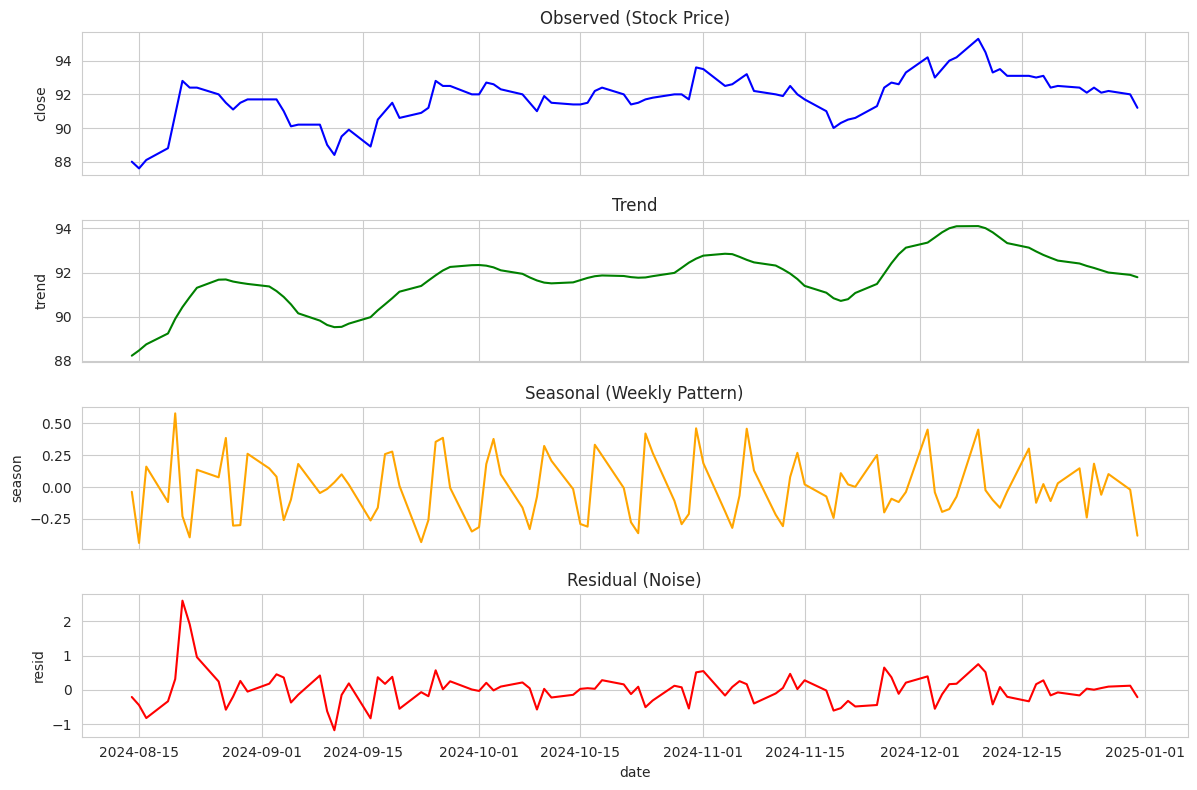

In [ ]:
# Seasonal Decomposition using STL (Seasonal-Trend Decomposition)
stl = sm.tsa.STL(df_filled['close'], period=5, robust=True) # period=5 because the data only have 5 days a week
stl_result = stl.fit()

def plot_last_n_weeks(stl_result, num_weeks=10):
    """
    Vẽ n tuần cuối cùng của kết quả phân tách STL
    """
    # Calculate the last N weeks
    last_n_days = num_weeks * 5
    subset = stl_result.observed.index[-last_n_days:]

    # Set seaborn style
    sns.set_style("whitegrid")

    # Create a figure with four subplots
    fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

    # Plot Observed Data
    sns.lineplot(x=subset, y=stl_result.observed.loc[subset], ax=axes[0], color="blue")
    axes[0].set_title("Observed (Stock Price)")

    # Plot Trend Component
    sns.lineplot(x=subset, y=stl_result.trend.loc[subset], ax=axes[1], color="green")
    axes[1].set_title("Trend")

    # Plot Seasonal Component
    sns.lineplot(x=subset, y=stl_result.seasonal.loc[subset], ax=axes[2], color="orange")
    axes[2].set_title("Seasonal (Weekly Pattern)")

    # Plot Residual Component
    sns.lineplot(x=subset, y=stl_result.resid.loc[subset], ax=axes[3], color="red")
    axes[3].set_title("Residual (Noise)")

    plt.tight_layout()
    plt.show()

# Vẽ 20 tuần cuối
plot_last_n_weeks(stl_result, num_weeks=20)



2. Kiểm tra tính dừng của dữ liệu:

Kiểm tra tính dừng cho close:
ADF Statistic: -3.1035208806943637
p-value: 0.02629372241174794
Critical Values:
	1%: -3.435374708138995
	5%: -2.863758995766637
	10%: -2.5679514065499265
=> Chuỗi dừng (stationary)


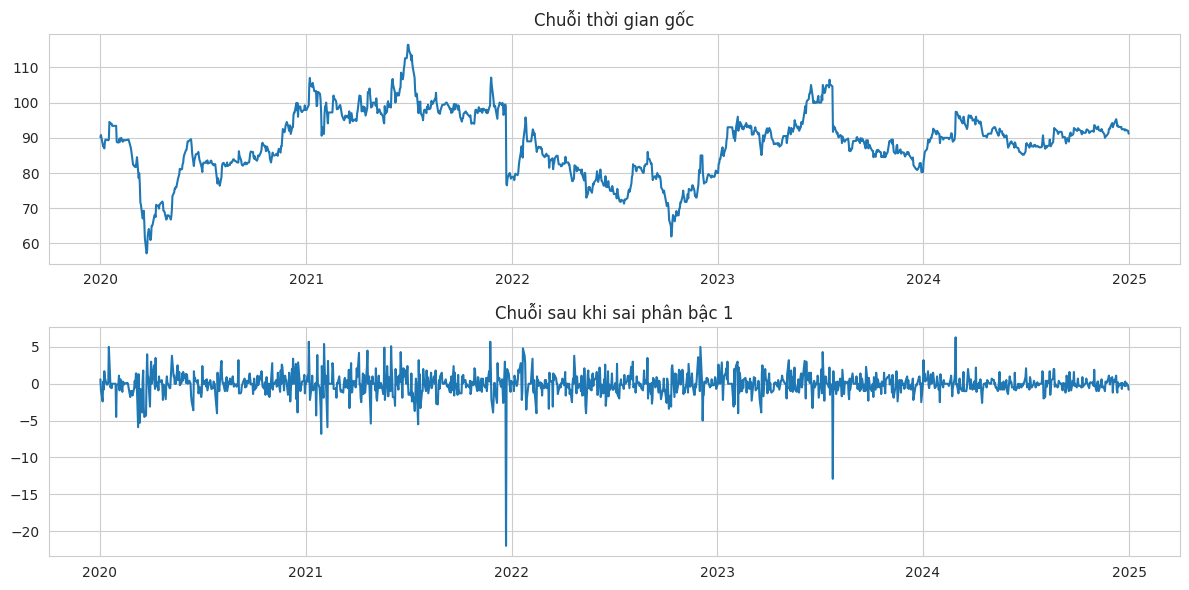

In [ ]:
# 2. Kiểm tra tính dừng của dữ liệu
print("\n2. Kiểm tra tính dừng của dữ liệu:")

def check_stationarity(timeseries, column_name=None):
    """
    Kiểm tra tính dừng bằng ADF test và vẽ biểu đồ
    """
    if column_name:
        print(f"\nKiểm tra tính dừng cho {column_name}:")

    # ADF Test
    result = adfuller(timeseries.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

    if result[1] <= 0.05:
        print("=> Chuỗi dừng (stationary)")
    else:
        print("=> Chuỗi không dừng (non-stationary), cần sai phân")

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.subplot(211)
    plt.plot(timeseries)
    plt.title('Chuỗi thời gian gốc')

    plt.subplot(212)
    plt.plot(timeseries.diff().dropna())
    plt.title('Chuỗi sau khi sai phân bậc 1')
    plt.tight_layout()
    plt.show()

# Kiểm tra tính dừng cho cột close
check_stationarity(df_filled['close'], 'close')



3. Vẽ ACF và PACF:


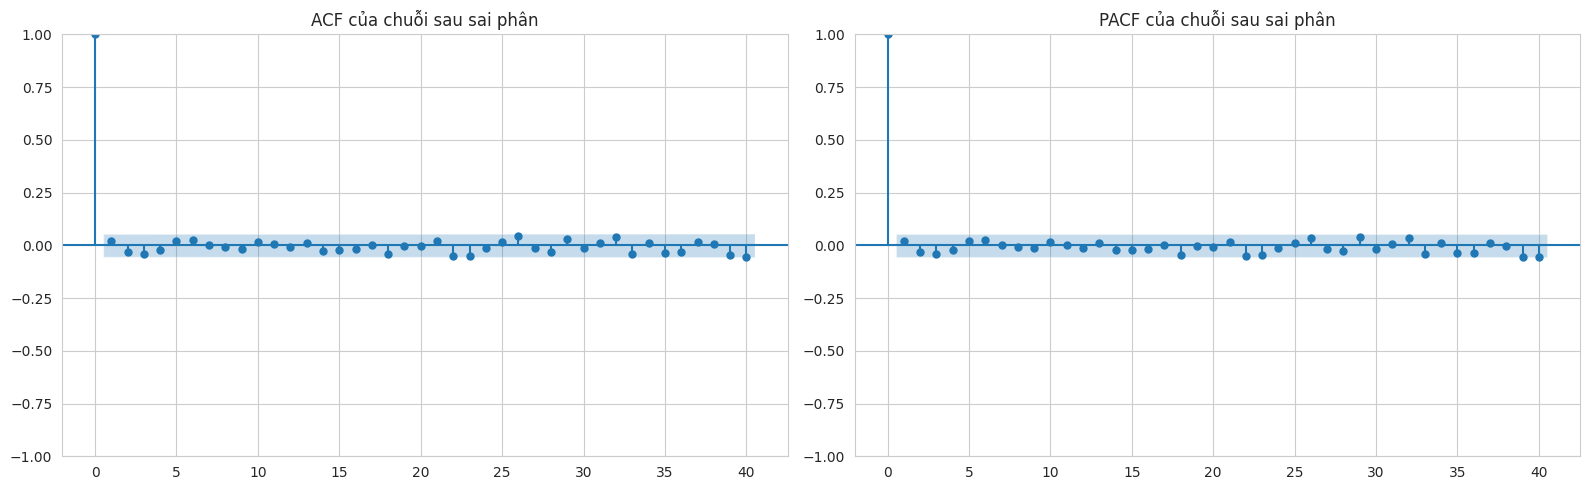

In [ ]:
# 3. Vẽ biểu đồ ACF và PACF
print("\n3. Vẽ ACF và PACF:")
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(df_filled['close'].diff().dropna(), ax=axes[0], lags=40)
plot_pacf(df_filled['close'].diff().dropna(), ax=axes[1], lags=40)
axes[0].set_title("ACF của chuỗi sau sai phân")
axes[1].set_title("PACF của chuỗi sau sai phân")
plt.tight_layout()
plt.show()

In [ ]:
!pip uninstall numpy
!pip install numpy


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/lib/python3.11/dist-packages/numpy-1.26.4.dist-info/*
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72.3.23.dev.so
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.11/dist-packages/numpy/*
Proceed (Y/n)? Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/uninstall.py", line 106, in run
    uninstall_pathset = req.uninstall(
                        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/req/req_install.py", line 722, in uni

In [ ]:
import numpy as np
print(np.__version__)


2.2.4


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Statsmodels version:", sm.__version__)


NumPy version: 2.2.4
Pandas version: 2.2.3
Statsmodels version: 0.14.4


In [ ]:
pip install --upgrade pandas pandasai

  Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 856.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 881.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━

Thông số cố định: SARIMA(1, 0, 1)(1, 0, 1, 5)

5. Chia dữ liệu thành tập train và test:
Train data: 2020-01-01 00:00:00 đến 2024-01-01 00:00:00
Test data: 2024-01-02 00:00:00 đến 2024-12-31 00:00:00

6. Xây dựng mô hình SARIMA với tham số tối ưu:


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                             close   No. Observations:                 1044
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 5)   Log Likelihood               -2011.025
Date:                           Tue, 18 Mar 2025   AIC                           4034.051
Time:                                   17:28:59   BIC                           4063.715
Sample:                               01-01-2020   HQIC                          4045.306
                                    - 01-01-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0027      1.121      0.895      0.371      -1.194       3.199
ar.L1          0.9859      0.006    172.972

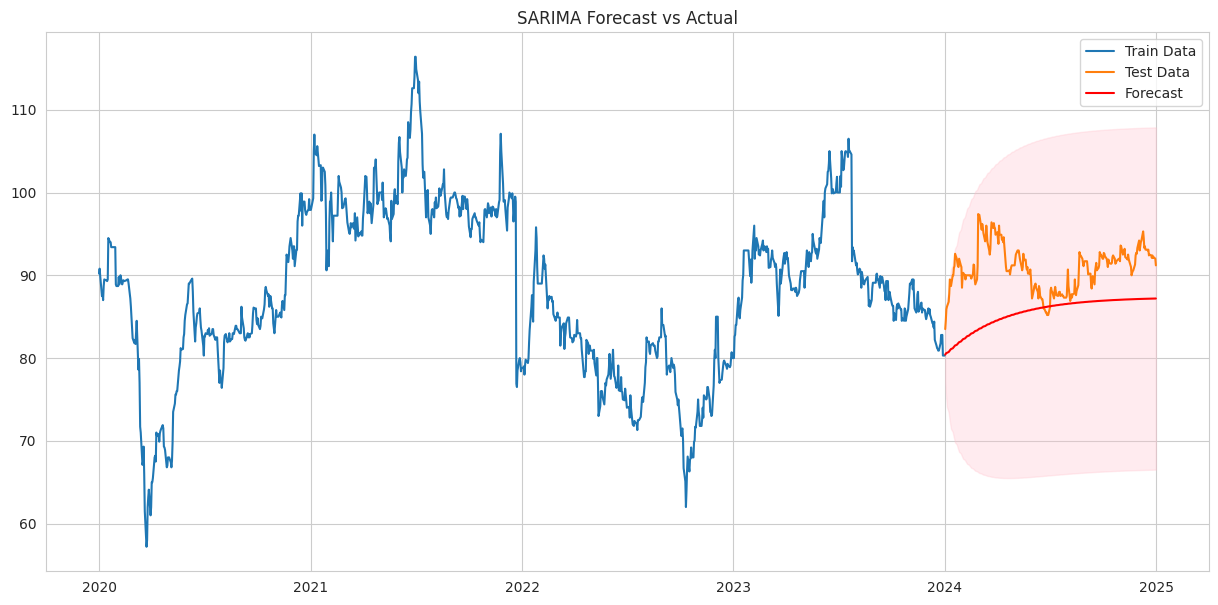


Đánh giá mô hình trên tập test:
RMSE: 6.2842
MSE: 39.4915
MAE: 5.4695
MAPE: 5.9399%

8. Kiểm tra phần dư của mô hình:


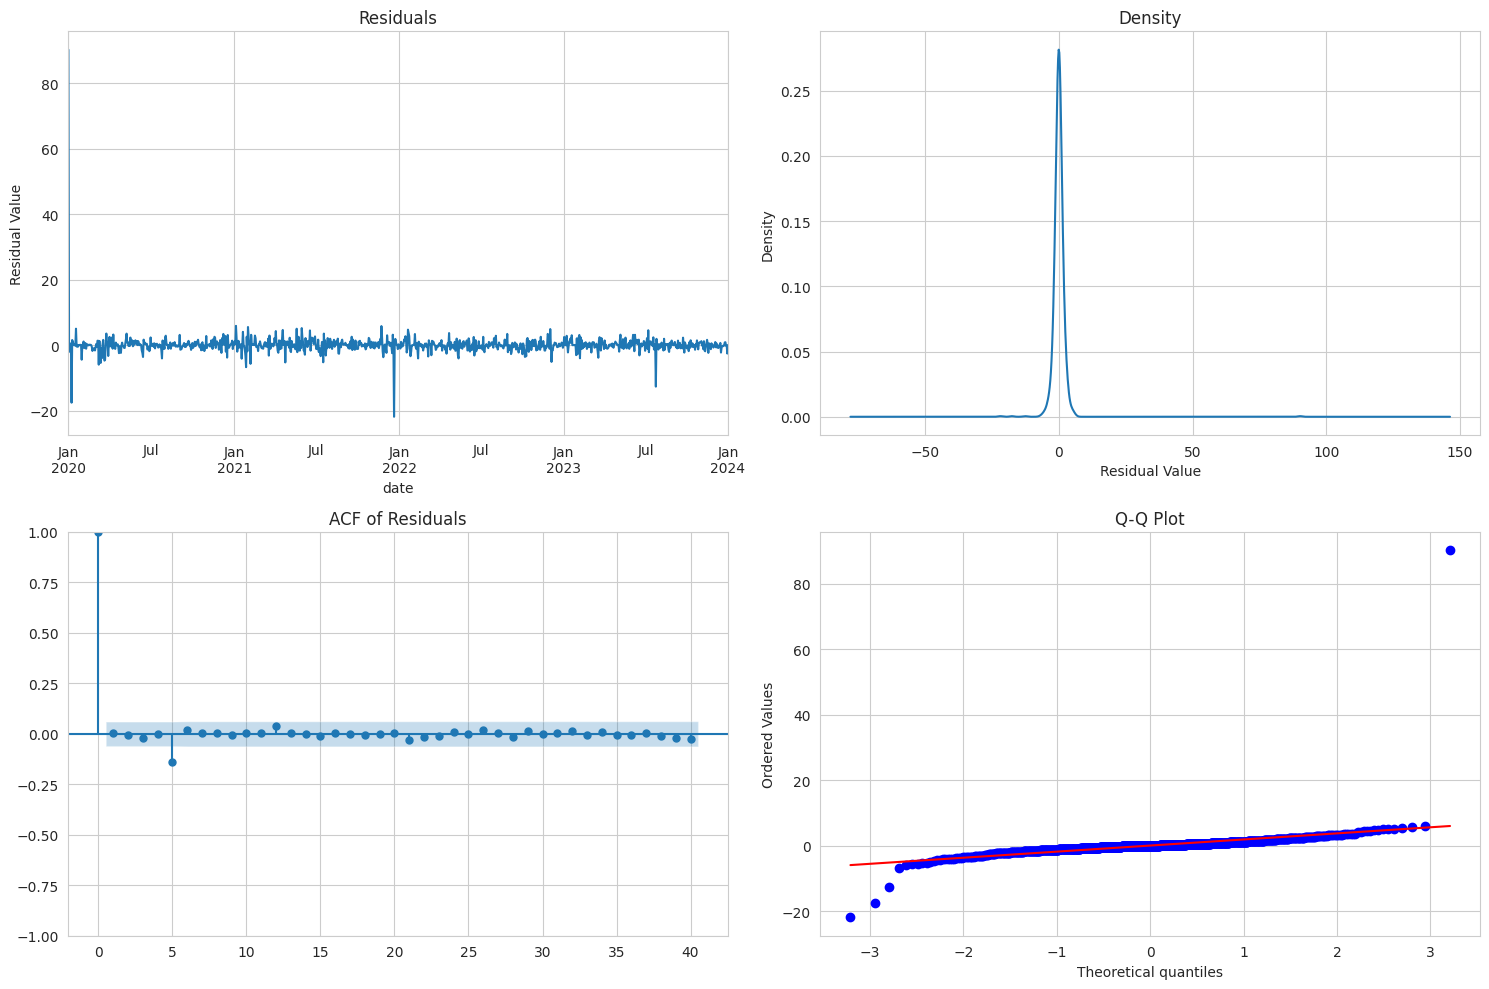


9. Dự báo giá trong tương lai:


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


Dự báo 10 ngày giao dịch tiếp theo:
             Forecast   Lower CI    Upper CI
Date                                        
2025-01-01  91.173021  88.113964   94.232078
2025-01-02  91.163030  86.791059   95.535001
2025-01-03  91.152924  85.780003   96.525844
2025-01-06  91.142570  84.928048   97.357091
2025-01-07  91.133818  84.178955   98.088681
2025-01-08  91.123578  83.500981   98.746175
2025-01-09  91.113579  82.877354   99.349804
2025-01-10  91.103490  82.296408   99.910571
2025-01-13  91.093209  81.750200  100.436217
2025-01-14  91.084172  81.234462  100.933882


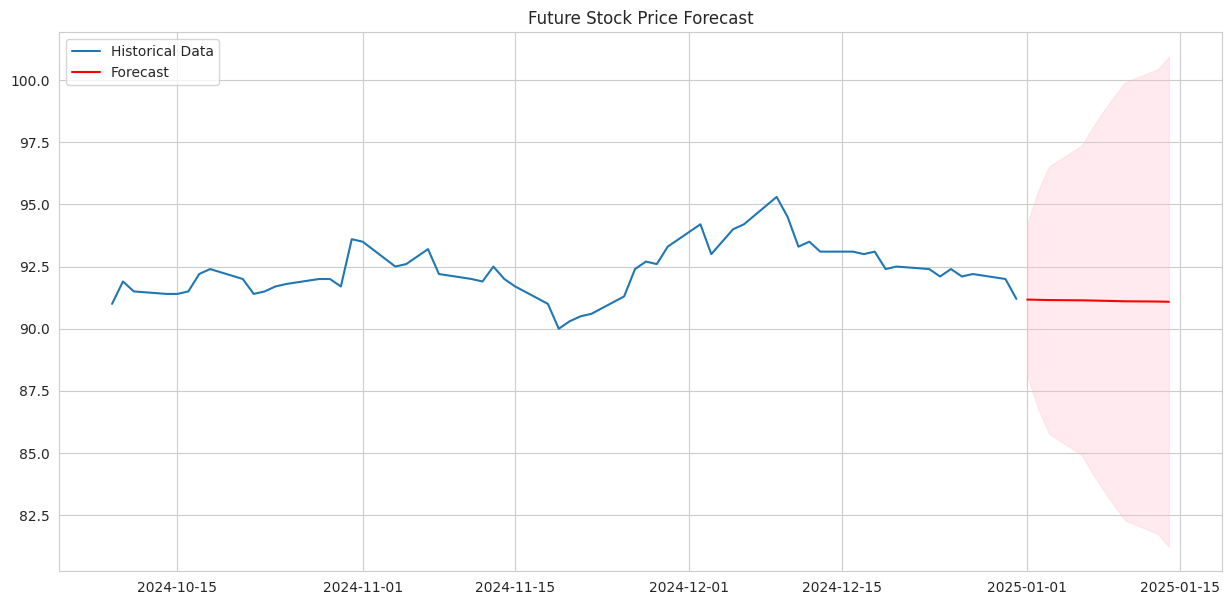


10. Time Series Cross-Validation:


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


Fold 1 - RMSE: 6.0768


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


Fold 2 - RMSE: 5.8360


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


Fold 3 - RMSE: 15.0413


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  

Fold 4 - RMSE: 16.2555
Fold 5 - RMSE: 19.8250

RMSE trung bình: 12.6069


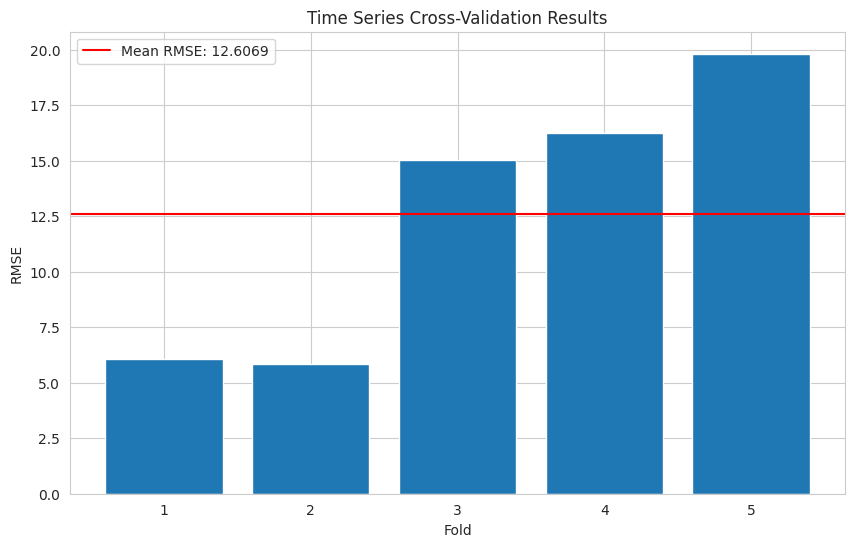


Phân tích hoàn tất!


In [ ]:
#Vì dữ liệu có tính dừng nên d = 0, không cần sai phân nữa
# Lấy thông số cố định cho SARIMA
optimal_order = (1,0,1)
optimal_seasonal_order = (1,0,1,5)
print(f"Thông số cố định: SARIMA{optimal_order}{optimal_seasonal_order}")

# 5. Chia dữ liệu thành tập train và test
print("\n5. Chia dữ liệu thành tập train và test:")
train_size = int(len(df_filled) * 0.8)
train_data = df_filled.iloc[:train_size]
test_data = df_filled.iloc[train_size:]

print(f"Train data: {train_data.index[0]} đến {train_data.index[-1]}")
print(f"Test data: {test_data.index[0]} đến {test_data.index[-1]}")

# 6. Xây dựng và huấn luyện mô hình SARIMA với tham số tối ưu
print("\n6. Xây dựng mô hình SARIMA với tham số tối ưu:")
sarima_model = sm.tsa.SARIMAX(train_data['close'],
                             order=optimal_order,
                             seasonal_order=optimal_seasonal_order,
                             enforce_stationarity=False,
                             enforce_invertibility=False,
                              trend='c')

sarima_result = sarima_model.fit(disp=False)
print(sarima_result.summary())

# 7. Đánh giá mô hình trên tập test
print("\n7. Đánh giá mô hình trên tập test:")

# Dự báo trên tập test (out-of-sample forecast)
forecast = sarima_result.get_forecast(steps=len(test_data))
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Tạo DataFrame cho dự báo
forecast_df = pd.DataFrame({
    'Actual': test_data['close'],
    'Forecast': forecast_values,
    'Lower CI': forecast_ci.iloc[:, 0],
    'Upper CI': forecast_ci.iloc[:, 1]
})

print("Kết quả dự báo (5 giá trị đầu):")
print(forecast_df.head())

# Vẽ biểu đồ dự báo
plt.figure(figsize=(15, 7))
plt.plot(train_data.index, train_data['close'], label='Train Data')
plt.plot(test_data.index, test_data['close'], label='Test Data')
plt.plot(test_data.index, forecast_values, label='Forecast', color='red')
plt.fill_between(test_data.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1],
                color='pink', alpha=0.3)
plt.title('SARIMA Forecast vs Actual')
plt.legend()
plt.show()

# Hàm đánh giá mô hình
def evaluate_model(actual, predicted):
    """
    Đánh giá mô hình bằng các metrics
    """
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100


    print(f'RMSE: {rmse:.4f}')
    print(f'MSE: {mse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'MAPE: {mape:.4f}%')


    return rmse, mse, mae, mape

# Đánh giá mô hình trên tập test
print("\nĐánh giá mô hình trên tập test:")
evaluate_model(test_data['close'], forecast_values)

# 8. Kiểm tra phần dư của mô hình
print("\n8. Kiểm tra phần dư của mô hình:")
residuals = sarima_result.resid
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Biểu đồ phần dư theo thời gian
residuals.plot(title="Residuals", ax=ax[0, 0])
ax[0, 0].set_ylabel('Residual Value')

# Biểu đồ phân phối phần dư
residuals.plot(kind='kde', title='Density', ax=ax[0, 1])
ax[0, 1].set_xlabel('Residual Value')

# ACF của phần dư
plot_acf(residuals, ax=ax[1, 0], lags=40)
ax[1, 0].set_title('ACF of Residuals')

# Q-Q plot
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=ax[1, 1])
ax[1, 1].set_title("Q-Q Plot")

plt.tight_layout()
plt.show()

# 9. Dự báo giá trong tương lai
print("\n9. Dự báo giá trong tương lai:")

# Huấn luyện lại mô hình với toàn bộ dữ liệu
final_model = sm.tsa.SARIMAX(df_filled['close'],
                            order=optimal_order,
                            seasonal_order=optimal_seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)

final_result = final_model.fit(disp=False)

# Dự báo 10 ngày giao dịch tiếp theo
forecast_steps = 10
future_forecast = final_result.get_forecast(steps=forecast_steps)
future_forecast_values = future_forecast.predicted_mean
future_forecast_ci = future_forecast.conf_int()

# Tạo ngày cho dự báo (chỉ ngày giao dịch - B: business day)
future_dates = pd.date_range(start=df_filled.index[-1] + pd.Timedelta(days=1),
                             periods=forecast_steps,
                             freq='B')

# Tạo DataFrame cho dự báo tương lai
future_forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecast': future_forecast_values.values,
    'Lower CI': future_forecast_ci.iloc[:, 0].values,
    'Upper CI': future_forecast_ci.iloc[:, 1].values
})

future_forecast_df.set_index('Date', inplace=True)
print("Dự báo 10 ngày giao dịch tiếp theo:")
print(future_forecast_df)

# Vẽ biểu đồ dự báo tương lai
plt.figure(figsize=(15, 7))
plt.plot(df_filled.index[-60:], df_filled['close'][-60:], label='Historical Data')
plt.plot(future_forecast_df.index, future_forecast_df['Forecast'], label='Forecast', color='red')
plt.fill_between(future_forecast_df.index,
                future_forecast_df['Lower CI'],
                future_forecast_df['Upper CI'],
                color='pink', alpha=0.3)
plt.title('Future Stock Price Forecast')
plt.legend()
plt.grid(True)
plt.show()

# 10. Time Series Cross-Validation để đánh giá độ ổn định của mô hình
print("\n10. Time Series Cross-Validation:")

def time_series_cv(data, n_splits=5):
    """
    Thực hiện time series cross-validation
    """
    # Xác định kích thước của mỗi fold
    fold_size = len(data) // (n_splits + 1)

    results = []

    for i in range(n_splits):
        # Chọn điểm cắt
        split_point = len(data) - fold_size * (i + 1)

        # Chia dữ liệu
        train = data.iloc[:split_point]
        test = data.iloc[split_point:split_point + fold_size]

        # Huấn luyện mô hình
        model = sm.tsa.SARIMAX(train['close'],
                              order=optimal_order,
                              seasonal_order=optimal_seasonal_order,
                              enforce_stationarity=False,
                              enforce_invertibility=False)

        model_fit = model.fit(disp=False)

        # Dự báo
        forecast = model_fit.get_forecast(steps=len(test))
        forecast_values = forecast.predicted_mean

        # Đánh giá
        rmse = np.sqrt(mean_squared_error(test['close'], forecast_values))

        results.append({
            'fold': i + 1,
            'train_size': len(train),
            'test_size': len(test),
            'rmse': rmse
        })

        print(f"Fold {i+1} - RMSE: {rmse:.4f}")

    # Tính RMSE trung bình
    avg_rmse = np.mean([r['rmse'] for r in results])
    print(f"\nRMSE trung bình: {avg_rmse:.4f}")

    return results

# Thực hiện time series cross-validation
cv_results = time_series_cv(df_filled, n_splits=5)

# Vẽ biểu đồ kết quả CV
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(cv_results) + 1), [r['rmse'] for r in cv_results])
plt.axhline(y=np.mean([r['rmse'] for r in cv_results]),
           color='r',
           linestyle='-',
           label=f'Mean RMSE: {np.mean([r["rmse"] for r in cv_results]):.4f}')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('Time Series Cross-Validation Results')
plt.legend()
plt.show()

print("\nPhân tích hoàn tất!")